In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
from math import log10

In [2]:
def stake_transformation(values, slope, curvature, threshold):
    transformed_stakes = []

    for x in values:
        if x <= 30e3:
            transformed_stakes.append(0.0001)
        elif x <= threshold:
            f_x = slope * x
            transformed_stakes.append(f_x)
        else:
            g_x = slope * threshold + (x - threshold) ** (1 / curvature)
            transformed_stakes.append(g_x)

    return transformed_stakes

def compute_apy(opt: dict, percentage: bool = False):
    transformed_stakings = stake_transformation(opt["data"], **opt["model_arguments"])

    probability = [s / sum(transformed_stakings) for s in transformed_stakings]

    rewards = [p * opt["budget"] for p in probability]

    period_apy = [r / s for r, s in zip(rewards, transformed_stakings)]
    yearly_apy = [apy * 12 / opt["period_in_months"] for apy in period_apy]
    
    apy = sum(yearly_apy) / len(yearly_apy)

    if percentage:
        return apy * 100
    
    return apy

def factor_and_prefix(value):
    factor = int(int(log10(value))/3)*3
    if factor < 3:
        prefix = ""
    elif factor < 6:
        prefix = "k"
    elif factor < 9:
        prefix = "M"

    return 10**factor, prefix

In [3]:
raw_all = pd.read_csv("all_01H7Z22K1VRTXCWJJJFV2A64VP.csv", low_memory=False)
raw_nft = pd.read_csv("nft_01H7Z2W99SMWJ01YN552WSRADV.csv", low_memory=False)

raw_data = pd.merge(raw_all, raw_nft, on="account", how="left")

condition = raw_data["token_id"].isnull()

staking_info_nft_holders = raw_data[~condition]
staking_info_non_nft_holders = raw_data[condition]
staking_info_all = raw_data

### Economic model

In [8]:
options = [{
    "data": staking_info_nft_holders["actual_stake_x"],
    "budget": 500_000,
    "period_in_months": 3,
    "model_arguments": {
        "slope": 1,
        "curvature":1.125,
        "threshold":0.5e6,
    },
    "legend": "only NR NFT holder"
},
{
    "data": staking_info_all["actual_stake_x"],
    "budget": 500_000,
    "period_in_months": 3,
    "model_arguments": {
        "slope": 1,
        "curvature":1.125,
        "threshold":0.5e6,
    },
    "legend": "everyone"
}]

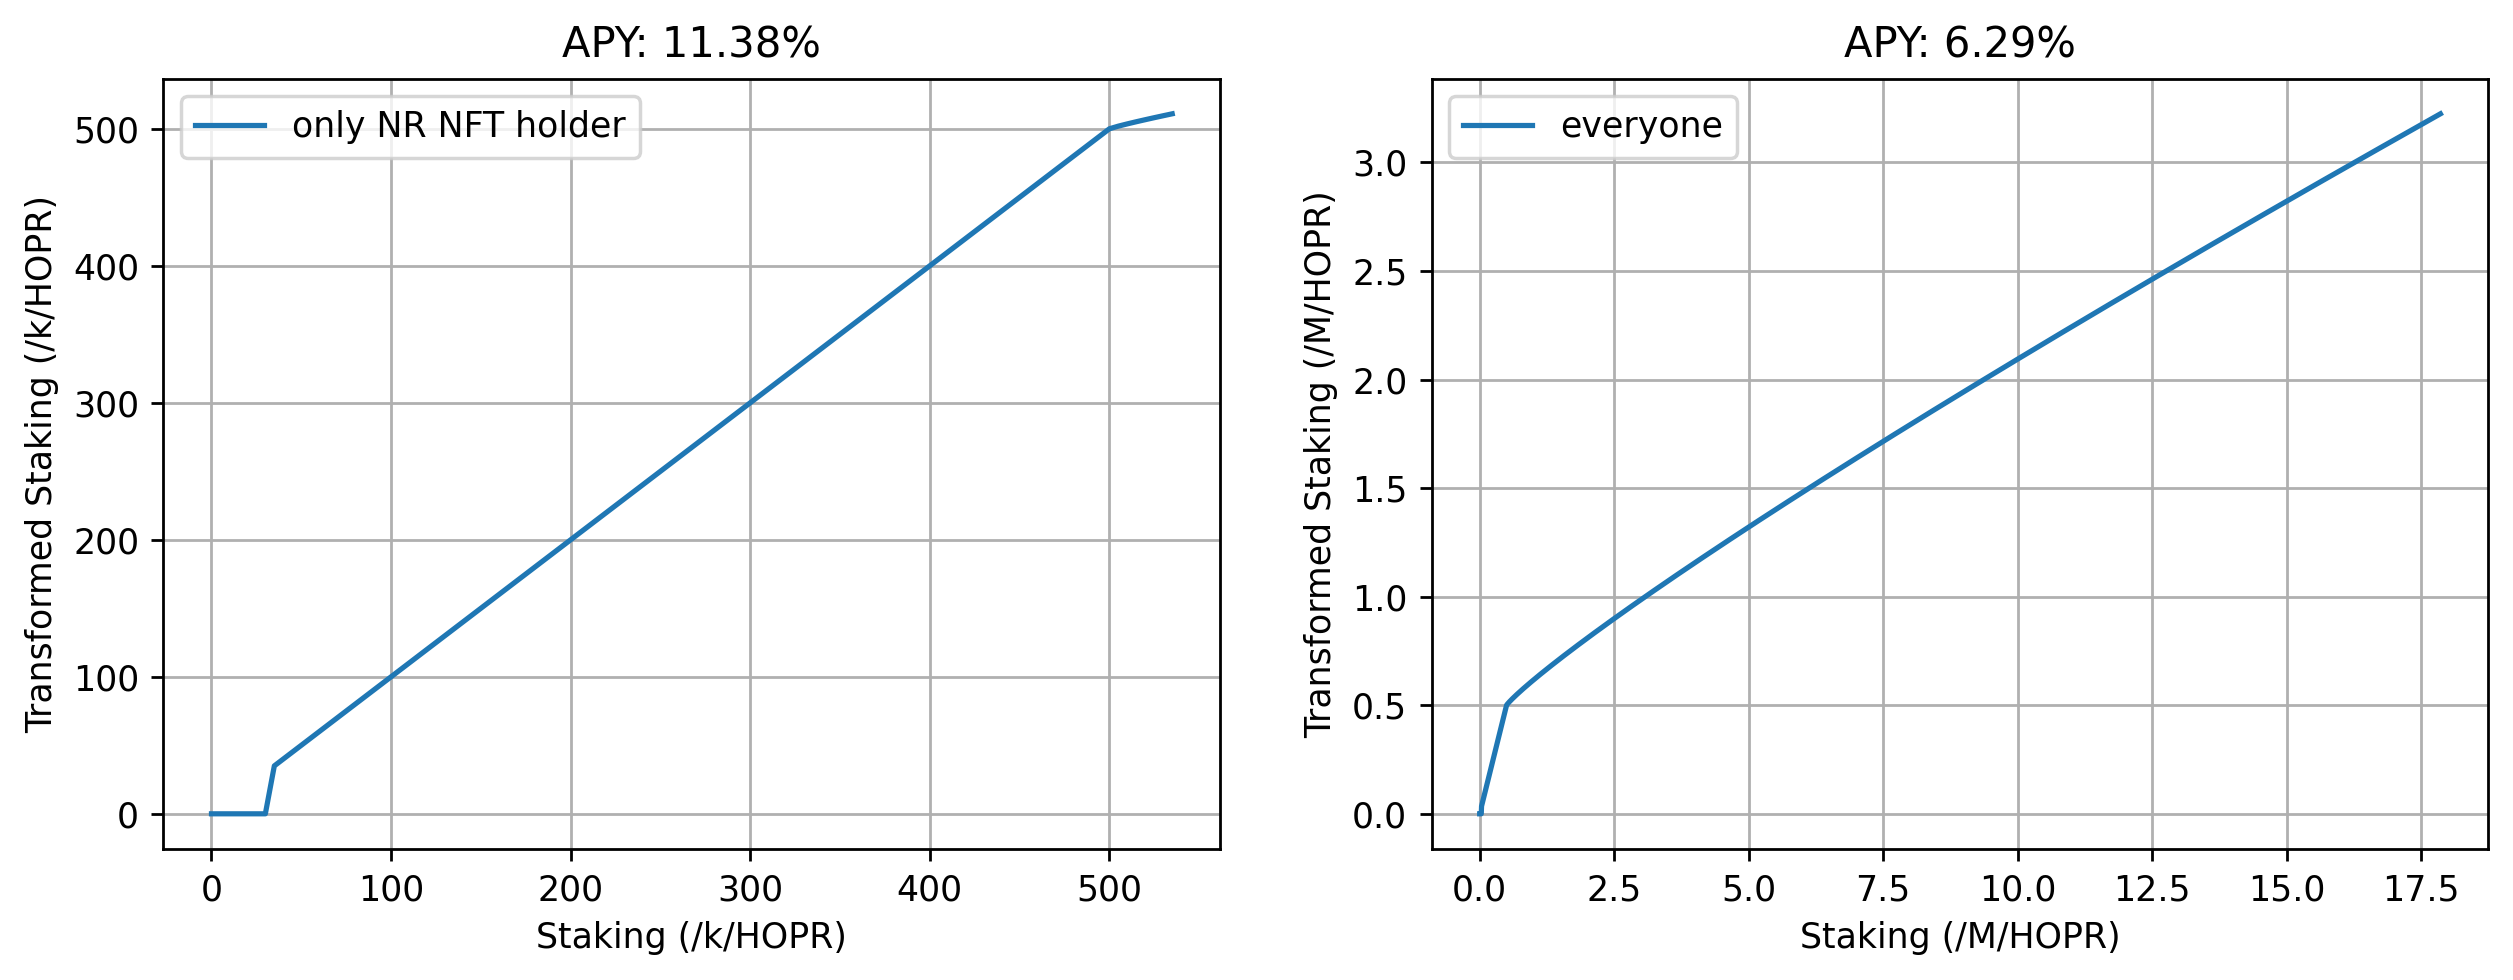

In [9]:
rows = 1
cols = int(len(options) / rows + 0.5)
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(cols*6,rows*4), dpi=250)

axes = [axes] if isinstance(axes, Axes) else axes.flatten()


for opt, ax in zip(options, axes):
    stakings = range(0, int(max(opt["data"])), 5000)
    transformed_stakings = stake_transformation(stakings, **opt["model_arguments"])
    
    factor, prefix = factor_and_prefix(stakings[-1])

    staking_for_plt = [s/factor for s in stakings]
    transformed_staking_for_plt = [s/factor for s in transformed_stakings]

    ax.set_title(f"APY: {compute_apy(opt, percentage=True):.2f}%")
    ax.plot(staking_for_plt, transformed_staking_for_plt, label=opt["legend"])
    ax.set_xlabel(f"Staking (/{prefix}/HOPR)")
    ax.set_ylabel(f"Transformed Staking (/{prefix}/HOPR)")
    ax.legend()
    ax.grid()

plt.show()